In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fruits


In [2]:
import os, random, math, time
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils

print("PyTorch", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

PyTorch 2.6.0+cu124
Device: cuda


In [3]:
DRIVE_OUT = Path('/content')


POSSIBLE = [
    Path('/kaggle/input/fruits/fruits-360_100x100/fruits-360')  # if running on Kaggle
]
DATA_ROOT = None
for p in POSSIBLE:
    if p and p.exists():
        DATA_ROOT = p
        break

if DATA_ROOT is None:
    print("No Fruits-360 detected automatically. Please upload or set DATA_ROOT manually.")
else:
    print("Using dataset root:", DATA_ROOT)

Using dataset root: /kaggle/input/fruits/fruits-360_100x100/fruits-360


In [4]:
IMG_SIZE = 64
BATCH_SIZE = 128
NUM_WORKERS = 2
NZ = 100
NGF = 64
NDF = 64
EPOCHS = 30
LR = 2e-4
BETA1 = 0.5


SINGLE_CLASS = None

SAMPLES_LIMIT_PER_CLASS = None

OUT_DIR = Path('/content/gan_out')
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Outputs will be saved to:", OUT_DIR)

Outputs will be saved to: /content/gan_out


In [5]:
if DATA_ROOT is None:
    raise RuntimeError("No DATA_ROOT found. Upload Fruits-360 or update DATA_ROOT path.")


train_root = None
if (DATA_ROOT / 'Training').exists():
    train_root = DATA_ROOT / 'Training'
elif (DATA_ROOT / 'training').exists():
    train_root = DATA_ROOT / 'training'
else:
    train_root = DATA_ROOT

print("Training root used:", train_root)

work_root = Path('/content/gan_dataset')
if work_root.exists():
    shutil.rmtree(work_root)
work_root.mkdir(parents=True, exist_ok=True)

if SINGLE_CLASS:
    src = train_root / SINGLE_CLASS
    if not src.exists():
        raise FileNotFoundError(f"SINGLE_CLASS {SINGLE_CLASS} not found under {train_root}")
    dst = work_root / SINGLE_CLASS
    shutil.copytree(src, dst)
    dataset_root = work_root
    print("Using single-class dataset:", dataset_root)
else:
    for cls in sorted([p for p in train_root.iterdir() if p.is_dir()]):
        dst = work_root / cls.name
        dst.mkdir(parents=True, exist_ok=True)
        imgs = sorted([p for p in cls.glob('*') if p.suffix.lower() in ('.jpg', '.png', '.jpeg')])
        if SAMPLES_LIMIT_PER_CLASS:
            imgs = imgs[:SAMPLES_LIMIT_PER_CLASS]
        for p in imgs:
            shutil.copy(p, dst/p.name)
    dataset_root = work_root
    print("Copied classes to working dataset at", dataset_root)

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)   # maps to [-1,1]
])

dataset = datasets.ImageFolder(str(dataset_root), transform=transform)
print("Dataset classes:", dataset.classes[:10], " (total classes:", len(dataset.classes), ")")
print("Dataset size:", len(dataset))

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

Training root used: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
Copied classes to working dataset at /content/gan_dataset
Dataset classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6']  (total classes: 207 )
Dataset size: 104456


In [6]:
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super().__init__()
        self.main = nn.Sequential(
            # input Z: (nz, 1, 1)
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False)
        )
        # Force final spatial to 1x1
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        x = self.features(x)          # -> (batch, 1, H, W) possibly
        x = self.adaptive_pool(x)    # -> (batch, 1, 1, 1)
        return x.view(-1)            # -> (batch,)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG = Generator(nz=NZ, ngf=NGF, nc=3).to(device)
netD = Discriminator(nc=3, ndf=NDF).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
# loss, optimizers, fixed noise
criterion = nn.BCEWithLogitsLoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

fixed_noise = torch.randn(64, NZ, 1, 1, device=device)  # for consistent sample grid
real_label = 1.
fake_label = 0.

# helper to save a grid of images
def save_sample(epoch, iters, out_dir=OUT_DIR):
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    grid = utils.make_grid(fake, nrow=8, normalize=True, value_range=None)
    out_path = Path(out_dir) / f"sample_epoch{epoch:03d}_iter{iters:06d}.png"
    utils.save_image(fake, str(out_path), nrow=8, normalize=True)
    return out_path

In [8]:
# training loop
iters = 0
G_losses = []
D_losses = []
start_time = time.time()
print("Starting Training Loop...")
for epoch in range(1, EPOCHS+1):
    for i, data in enumerate(dataloader, 0):
         #Update D network

        netD.zero_grad()
        real_imgs = data[0].to(device)
        b_size = real_imgs.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_imgs)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # generate fake
        noise = torch.randn(b_size, NZ, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()


        #  Update G network

        netG.zero_grad()
        label.fill_(real_label)  # want generator to fool discriminator
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # save losses and print
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if i % 100 == 0:
            print(f"[{epoch}/{EPOCHS}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")
        # save sample occasionally
        if iters % 500 == 0:
            sample_path = save_sample(epoch, iters)
            print("Saved sample to:", sample_path)
        iters += 1

    # save checkpoint each epoch
    ckpt_g = OUT_DIR / f'netG_epoch{epoch:03d}.pth'
    ckpt_d = OUT_DIR / f'netD_epoch{epoch:03d}.pth'
    torch.save(netG.state_dict(), str(ckpt_g))
    torch.save(netD.state_dict(), str(ckpt_d))
    print(f"Saved checkpoints: {ckpt_g.name}, {ckpt_d.name} (epoch {epoch})")

print("Training complete in", time.time() - start_time, "seconds")

Starting Training Loop...
[1/30][0/817]	Loss_D: 1.5270	Loss_G: 0.9719	D(x): -0.1459	D(G(z)): 0.0964/-0.4851
Saved sample to: /content/gan_out/sample_epoch001_iter000000.png
[1/30][100/817]	Loss_D: 0.7437	Loss_G: 1.6642	D(x): 0.9780	D(G(z)): -0.8117/-1.4440
[1/30][200/817]	Loss_D: 0.1637	Loss_G: 3.4528	D(x): 3.1306	D(G(z)): -2.2202/-3.4204
[1/30][300/817]	Loss_D: 0.2770	Loss_G: 3.1638	D(x): 2.0891	D(G(z)): -2.1995/-3.1156
[1/30][400/817]	Loss_D: 0.8748	Loss_G: 1.1832	D(x): 0.2992	D(G(z)): -1.1464/-0.8065
[1/30][500/817]	Loss_D: 0.8364	Loss_G: 1.1431	D(x): 0.2384	D(G(z)): -1.4675/-0.7445
Saved sample to: /content/gan_out/sample_epoch001_iter000500.png
[1/30][600/817]	Loss_D: 0.7234	Loss_G: 2.3137	D(x): 1.2141	D(G(z)): -0.6553/-2.2003
[1/30][700/817]	Loss_D: 1.0808	Loss_G: 0.9632	D(x): 0.0759	D(G(z)): -0.8284/-0.4488
[1/30][800/817]	Loss_D: 1.0110	Loss_G: 1.2383	D(x): 0.6557	D(G(z)): -0.3452/-0.8730
Saved checkpoints: netG_epoch001.pth, netD_epoch001.pth (epoch 1)
[2/30][0/817]	Loss_D: 1.

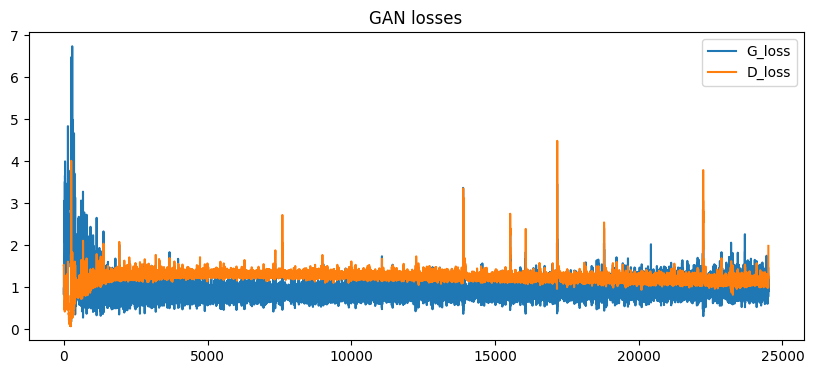

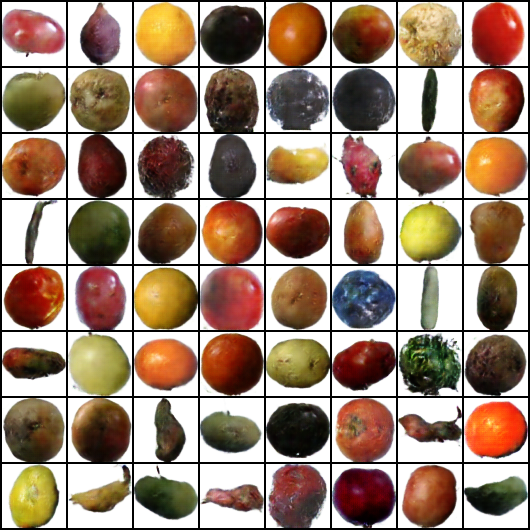

In [9]:
# plot losses and display last saved samples
plt.figure(figsize=(10,4))
plt.plot(G_losses, label='G_loss')
plt.plot(D_losses, label='D_loss')
plt.legend()
plt.title("GAN losses")
plt.show()

# show several sample images from output folder (last epoch)
samples = sorted(list(OUT_DIR.glob('sample_epoch*.png')))
if samples:
    display(Image.open(samples[-1]))
else:
    print("No sample images found in", OUT_DIR)

In [10]:
# generate new images using the trained generator
def generate_images(netG, n=20, batch_size=64, out_dir=OUT_DIR, nz=NZ):
    netG.eval()
    out_dir = Path(out_dir) / 'generated'
    out_dir.mkdir(parents=True, exist_ok=True)
    total = 0
    while total < n:
        cur = min(batch_size, n - total)
        noise = torch.randn(cur, nz, 1, 1, device=device)
        with torch.no_grad():
            fake = netG(noise).cpu()
        for i in range(cur):
            path = out_dir / f'gen_{total+i:04d}.png'
            utils.save_image(fake[i], str(path), normalize=True)
        total += cur
    print(f"Saved {n} images to {out_dir}")
    return out_dir

gen_dir = generate_images(netG, n=50, batch_size=50)
print("Generated images folder:", gen_dir)

Saved 50 images to /content/gan_out/generated
Generated images folder: /content/gan_out/generated
